In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
# Load the datasets
hist_df = pd.read_csv('historical_data.csv')
fg_df = pd.read_csv('fear_greed_index.csv')

# Convert date columns to datetime
hist_df['Timestamp IST'] = pd.to_datetime(hist_df['Timestamp IST'], format='%d-%m-%Y %H:%M')
fg_df['date'] = pd.to_datetime(fg_df['date'])

# Create 'date' column in hist_df from Timestamp IST
hist_df['date'] = hist_df['Timestamp IST'].dt.date
hist_df['date'] = pd.to_datetime(hist_df['date'])

# Optional: Add a formatted string version of the date (DD-MM-YYYY)
fg_df['formatted_date'] = fg_df['date'].dt.strftime('%d-%m-%Y')
hist_df['formatted_date'] = hist_df['date'].dt.strftime('%d-%m-%Y')

# Merge on the datetime 'date' column (not the formatted one)
merged_df = hist_df.merge(fg_df[['date', 'classification']], on='date', how='left')


In [ ]:
hist_df.isnull().sum()
fg_df.isnull().sum()

timestamp         0
value             0
classification    0
date              0
formatted_date    0
dtype: int64

Calculating the trader performance metrics

In [ ]:
# Fill missing Closed PnL with 0 for calculations if any
merged_df['Closed PnL'] = merged_df['Closed PnL'].fillna(0)
merged_df['Size USD'] = merged_df['Size USD'].replace(0, np.nan) o

# Group by account and sentiment classification
performance = merged_df.groupby(['Account', 'classification']).agg(
    total_trades=('Trade ID', 'count'),
    win_rate=('Closed PnL', lambda x: (x > 0).sum() / len(x) if len(x) > 0 else 0),
    total_pnl=('Closed PnL', 'sum'),
    avg_pnl=('Closed PnL', 'mean'),
    total_usd=('Size USD', 'sum'),
    pnl_std=('Closed PnL', 'std')
).reset_index()

performance['ROI'] = performance['total_pnl'] / performance['total_usd']


In [13]:
print(merged_df.columns.tolist())

['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp', 'date', 'formatted_date', 'classification']


In [ ]:
# Sort traders within each sentiment class by highest ROI
top_traders = performance.sort_values(['classification', 'ROI'], ascending=[True, False])

performance.to_csv('trader_performance_summary.csv', index=False)   


# Visualizing Patterns

##### ROI by sentiment type

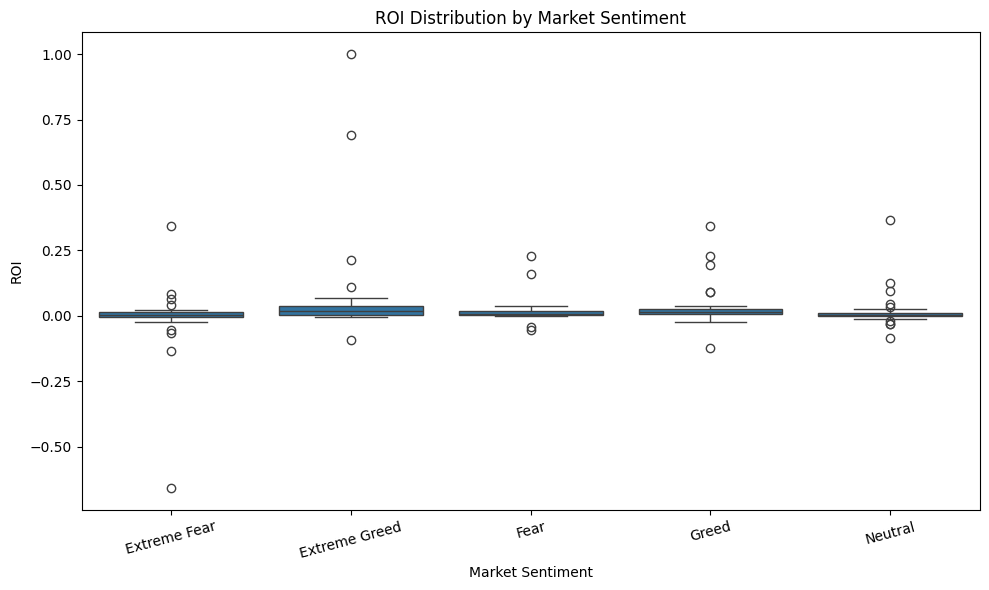

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(x='classification', y='ROI', data=performance)
plt.title('ROI Distribution by Market Sentiment')
plt.ylabel('ROI')
plt.xlabel('Market Sentiment')
plt.xticks(rotation=15)
plt.tight_layout()
#plt.show()
plt.savefig('roi_distribution.png')

#### Average PnL by classification

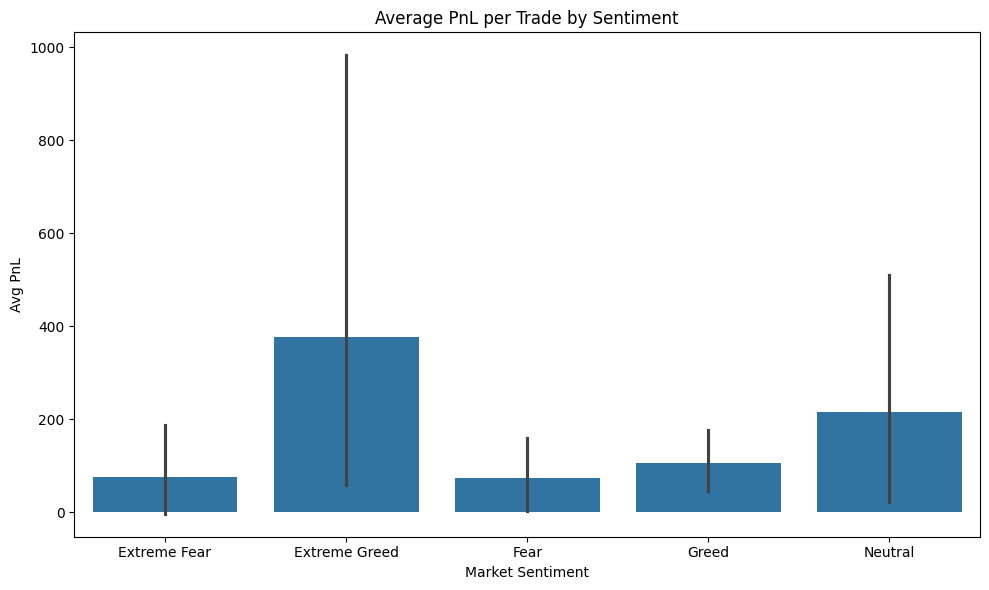

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(x='classification', y='avg_pnl', data=performance, estimator=np.mean)
plt.title('Average PnL per Trade by Sentiment')
plt.ylabel('Avg PnL')
plt.xlabel('Market Sentiment')
plt.tight_layout()
#plt.show()
plt.savefig('average_pnl.png')

#### Heatmap of Traders and sentiment ROI

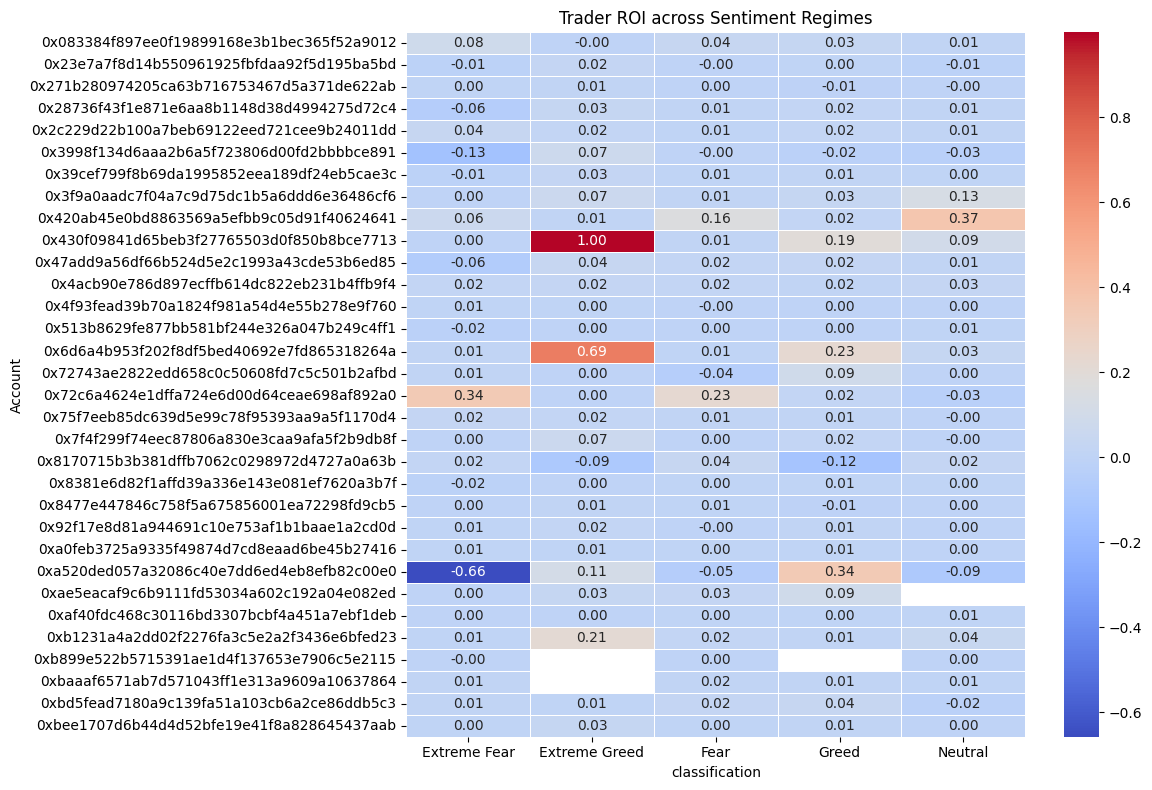

In [32]:
pivot = performance.pivot(index='Account', columns='classification', values='ROI')
plt.figure(figsize=(12,8))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Trader ROI across Sentiment Regimes")
plt.tight_layout()
#plt.show()
plt.savefig('trader_roi_heatmap.png')

#### Traders activeness across sentiment regimes

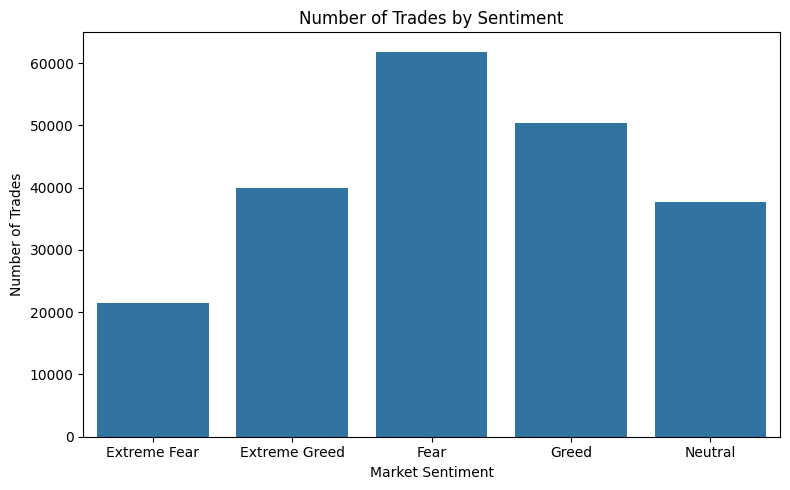

In [ ]:
trade_counts = merged_df.groupby('classification')['Trade ID'].count().reset_index()

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.barplot(x='classification', y='Trade ID', data=trade_counts)
plt.title('Number of Trades by Sentiment')
plt.ylabel('Number of Trades')
plt.xlabel('Market Sentiment')
plt.tight_layout()
plt.savefig('trade_volume_by_sentiment.png')


#### Top Traders in each sentiment

In [29]:
top_traders_fear = performance[performance['classification'] == 'Fear'].sort_values('ROI', ascending=False).head(5)
top_traders_greed = performance[performance['classification'] == 'Greed'].sort_values('ROI', ascending=False).head(5)

print("Top 5 Traders During Fear:")
print(top_traders_fear[['Account', 'ROI', 'win_rate']])

print("\nTop 5 Traders During Greed:")
print(top_traders_greed[['Account', 'ROI', 'win_rate']])


Top 5 Traders During Fear:
                                        Account       ROI  win_rate
82   0x72c6a4624e1dffa724e6d00d64ceae698af892a0  0.228753  0.645012
42   0x420ab45e0bd8863569a5efbb9c05d91f40624641  0.161396  0.357143
2    0x083384f897ee0f19899168e3b1bec365f52a9012  0.036791  0.526434
97   0x8170715b3b381dffb7062c0298972d4727a0a63b  0.036278  0.296848
127  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  0.027675  0.349593

Top 5 Traders During Greed:
                                        Account       ROI  win_rate
123  0xa520ded057a32086c40e7dd6ed4eb8efb82c00e0  0.344845  0.953704
73   0x6d6a4b953f202f8df5bed40692e7fd865318264a  0.227184  0.506224
48   0x430f09841d65beb3f27765503d0f850b8bce7713  0.193793  0.637306
128  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  0.090143  0.447059
78   0x72743ae2822edd658c0c50608fd7c5c501b2afbd  0.089827  0.317032


#### Win Rate by Sentiment

C:\Users\hp\AppData\Local\Temp\ipykernel_24488\3826325361.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  win_rate_sentiment = merged_df.groupby('classification').apply(


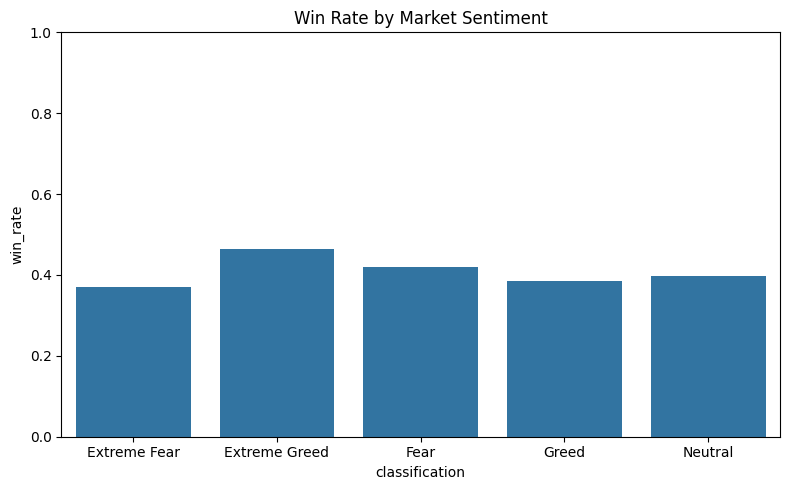

In [ ]:
#How often do traders win by sentiment

win_rate_sentiment = merged_df.groupby('classification').apply(
    lambda x: (x['Closed PnL'] > 0).sum() / len(x)
).reset_index(name='win_rate')

plt.figure(figsize=(8,5))
sns.barplot(x='classification', y='win_rate', data=win_rate_sentiment)
plt.title('Win Rate by Market Sentiment')
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig('win_rate_by_sentiment.png')
plt.show()
